In [2]:
import numpy as np

In [61]:
theta = -45
rot= np.vstack([[np.cos(theta * np.pi /180), -np.sin(theta * np.pi /180)], [np.sin(theta * np.pi /180), np.cos(theta * np.pi /180)]])
print(1/rot, np.sqrt(2))

[[ 1.41421356  1.41421356]
 [-1.41421356  1.41421356]] 1.4142135623730951


In [57]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            1 / np.exp(self.opt.xc), ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        plt.show()
        self.start += 1



3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]



  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_26009/938195954.py:42: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_26009/938195954.py:63: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_26009/938195954.py:67: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarnin

0.05000565607090478
2.5629458381997265
0.07156090021259899
0.15503745179373832


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

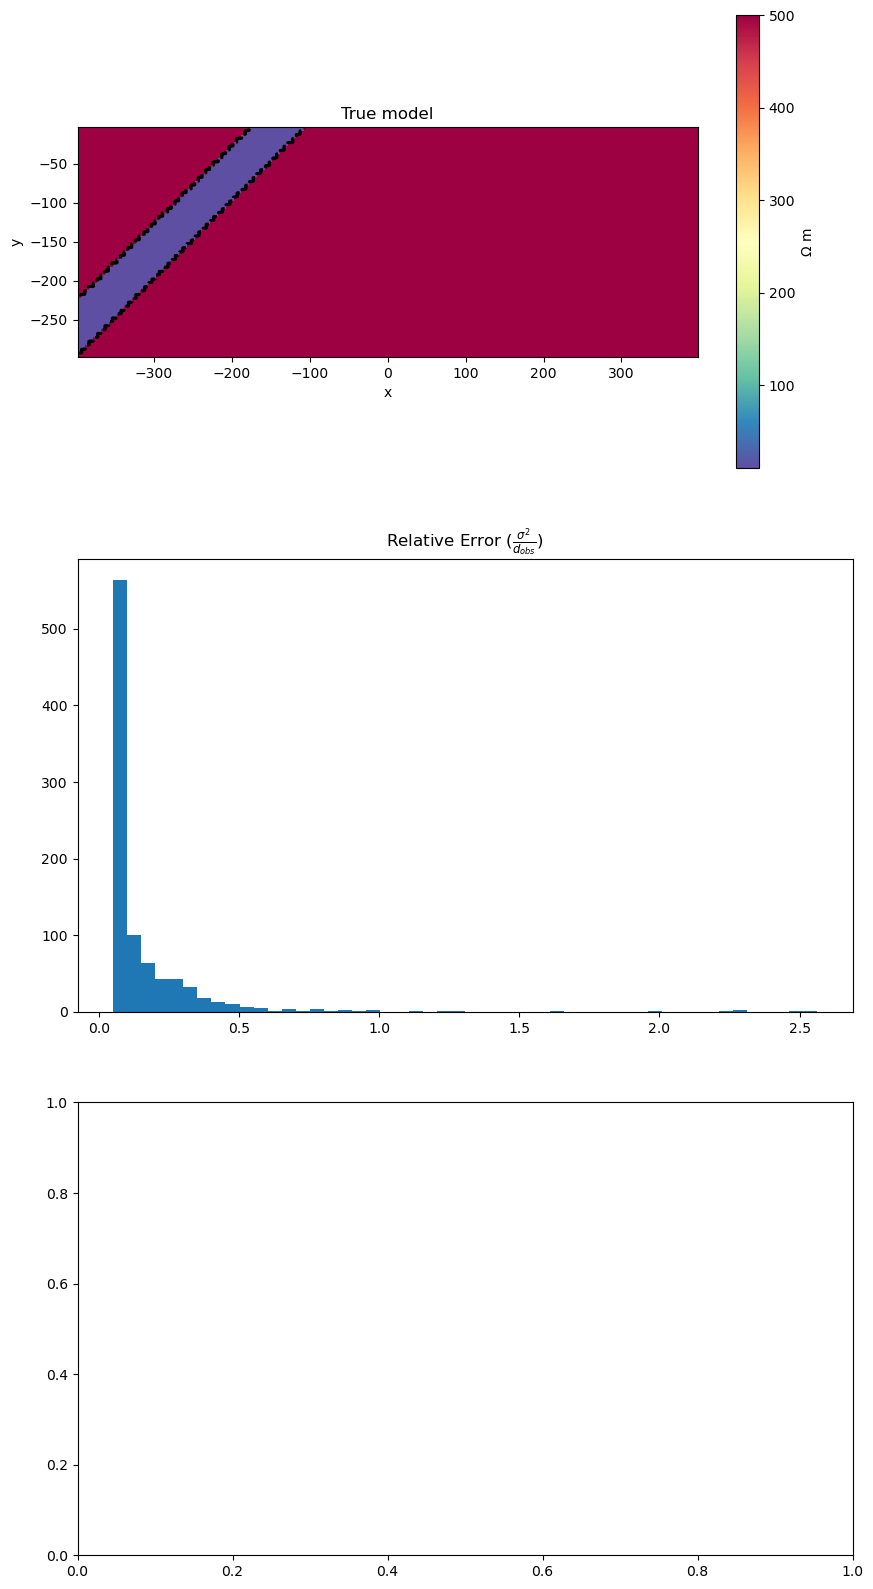

In [62]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 45*
dike0 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 100)
dike1 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 175)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.05
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=1e-3,
    force=True,
    add_noise=True,

)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

/tmp/ipykernel_26009/2373943619.py:98: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
/tmp/ipykernel_26009/2373943619.py:98: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)


SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  9.70e+05  0.00e+00  9.70e+05    6.52e+04      0              
geophys. misfits: 97054.0 (target 460.0 [False])
Beta cooling evaluation: progress: [97054.]; minimum progress targets: [873270.3]


/tmp/ipykernel_26009/1634548562.py:71: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],


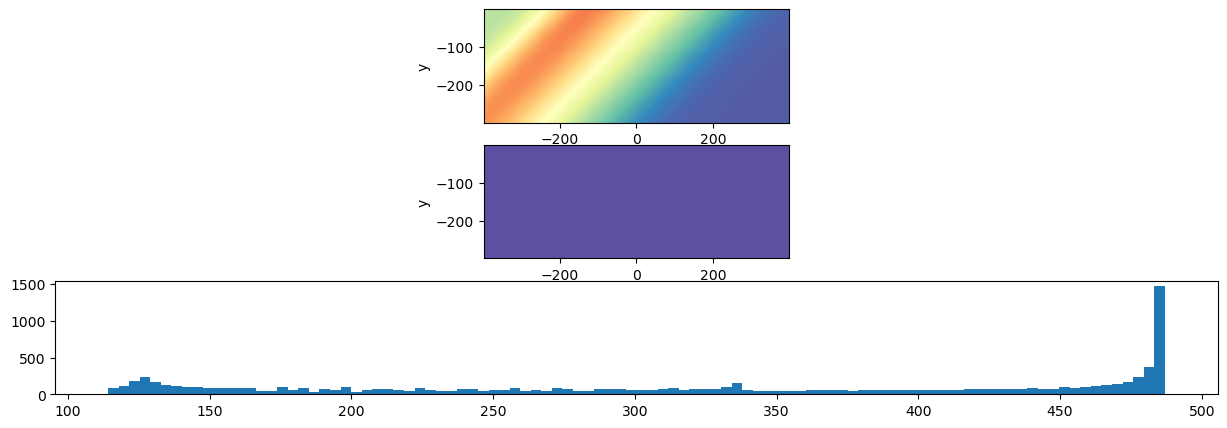

   1  1.00e-02  9.71e+04  3.40e+00  9.71e+04    9.29e+03      0              
geophys. misfits: 22964.7 (target 460.0 [False])
Beta cooling evaluation: progress: [22964.7]; minimum progress targets: [87348.6]


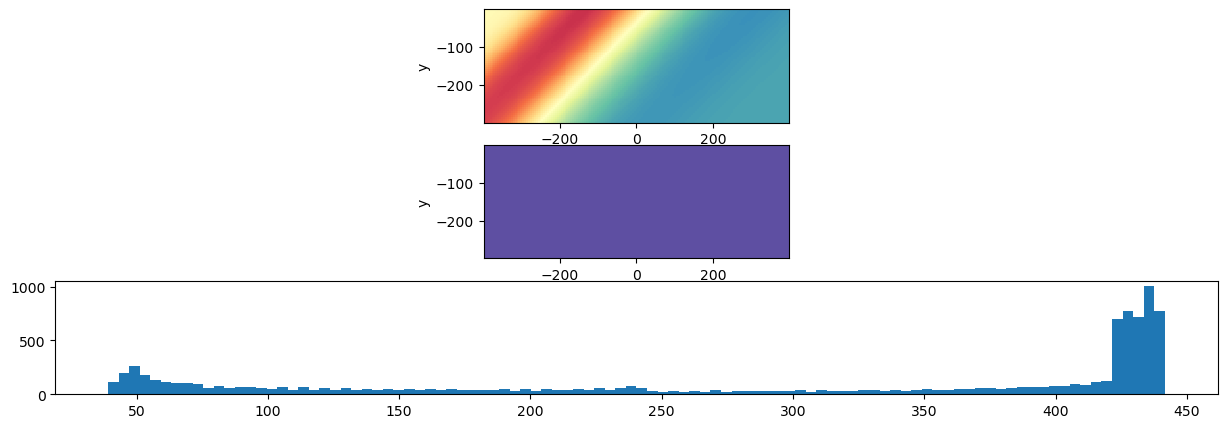

   2  1.00e-02  2.30e+04  1.21e+01  2.30e+04    1.66e+03      0   Skip BFGS  
geophys. misfits: 13466.5 (target 460.0 [False])
Beta cooling evaluation: progress: [13466.5]; minimum progress targets: [20668.3]


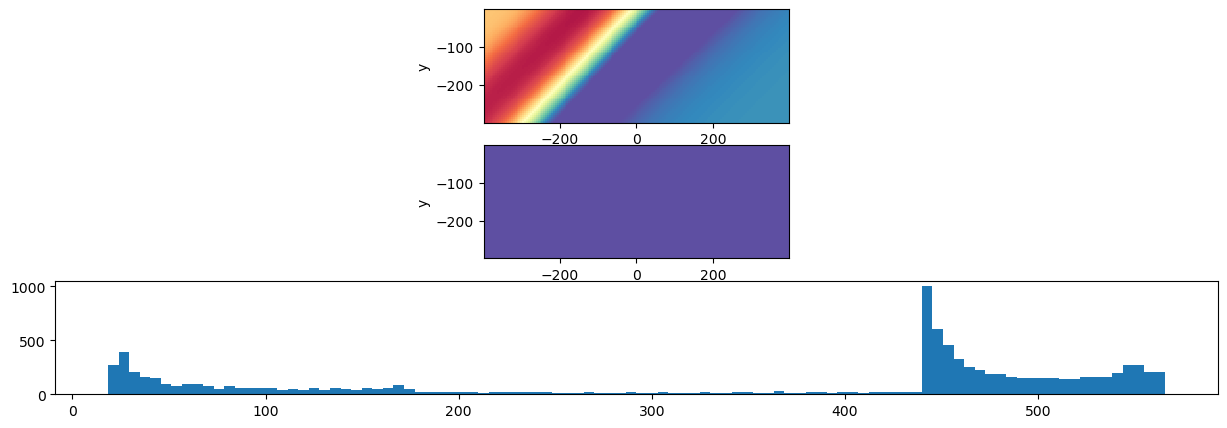

   3  1.00e-02  1.35e+04  2.64e+01  1.35e+04    8.10e+02      0   Skip BFGS  
geophys. misfits: 10194.7 (target 460.0 [False])
Beta cooling evaluation: progress: [10194.7]; minimum progress targets: [12119.8]


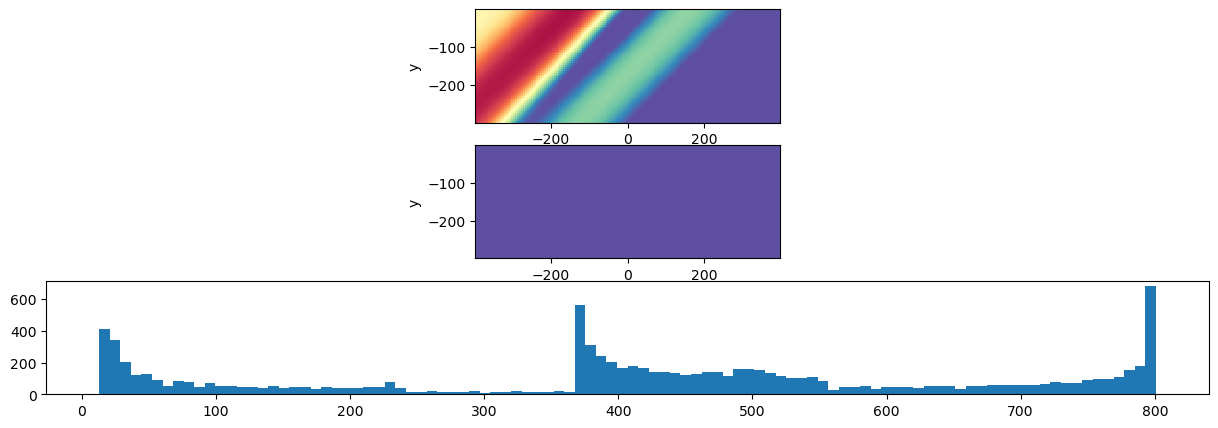

   4  1.00e-02  1.02e+04  4.82e+01  1.02e+04    7.49e+02      0   Skip BFGS  
geophys. misfits: 8982.6 (target 460.0 [False])
Beta cooling evaluation: progress: [8982.6]; minimum progress targets: [9175.2]


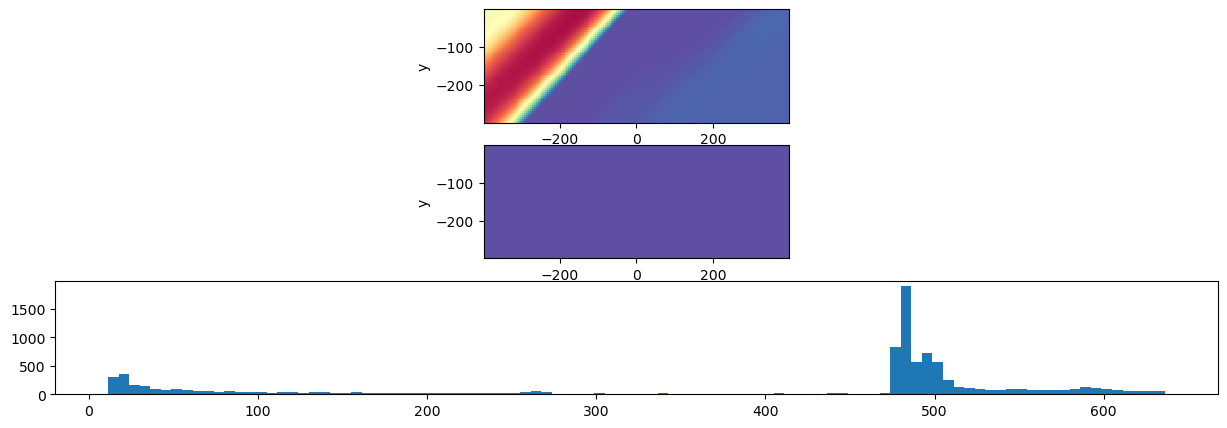

   5  1.00e-02  8.98e+03  5.65e+01  8.98e+03    7.14e+02      0              
geophys. misfits: 6108.0 (target 460.0 [False])
Beta cooling evaluation: progress: [6108.]; minimum progress targets: [8084.4]


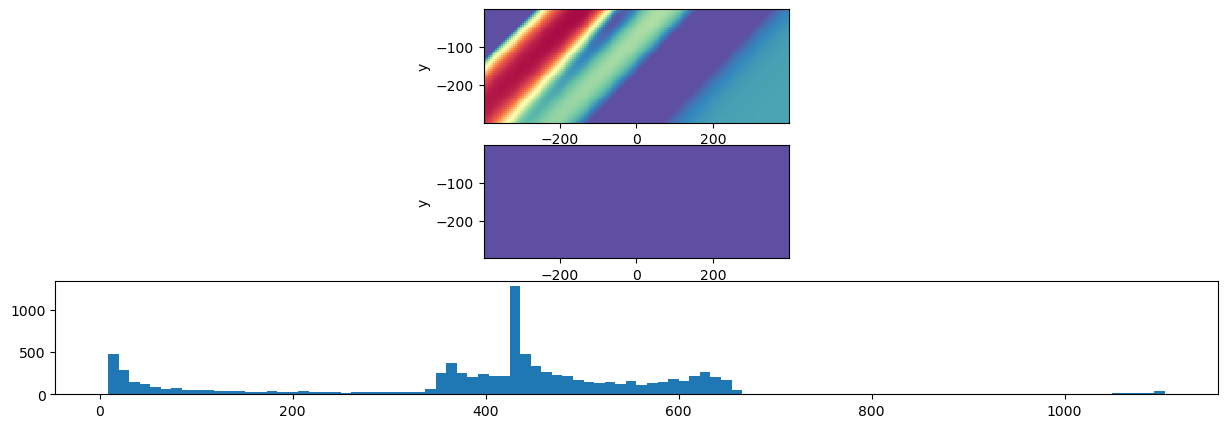

   6  1.00e-02  6.11e+03  1.03e+02  6.11e+03    5.59e+02      0              
geophys. misfits: 5397.0 (target 460.0 [False])
Beta cooling evaluation: progress: [5397.]; minimum progress targets: [5497.2]


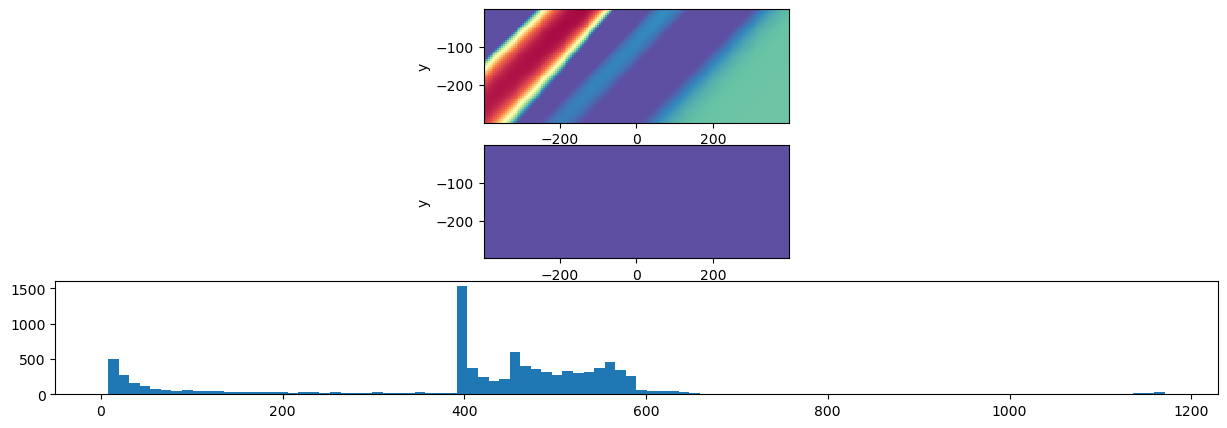

   7  1.00e-02  5.40e+03  1.17e+02  5.40e+03    5.62e+02      0              
geophys. misfits: 4795.5 (target 460.0 [False])
Beta cooling evaluation: progress: [4795.5]; minimum progress targets: [4857.3]


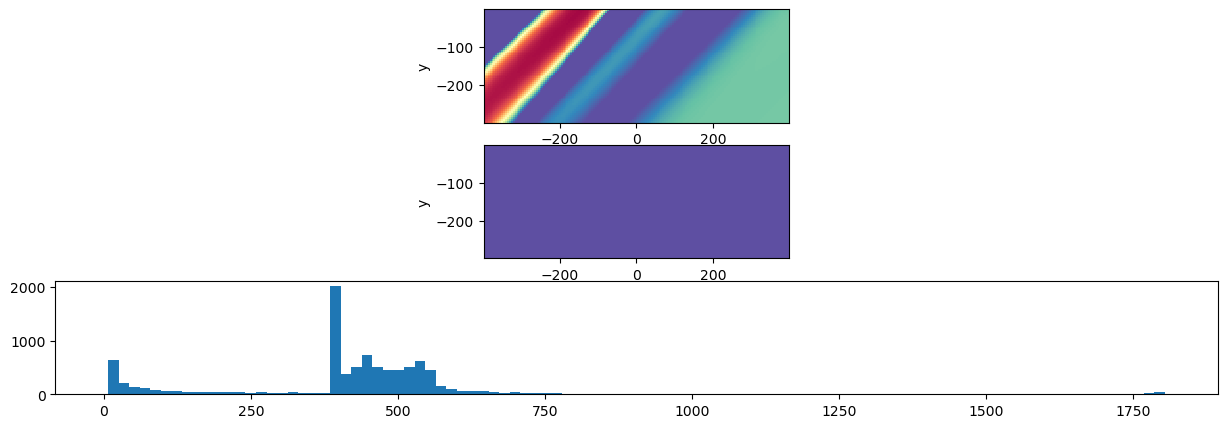

   8  1.00e-02  4.80e+03  1.50e+02  4.80e+03    5.11e+02      0   Skip BFGS  
geophys. misfits: 4610.9 (target 460.0 [False])
Beta cooling evaluation: progress: [4610.9]; minimum progress targets: [4315.9]
Decreasing beta to counter data misfit decrase plateau.


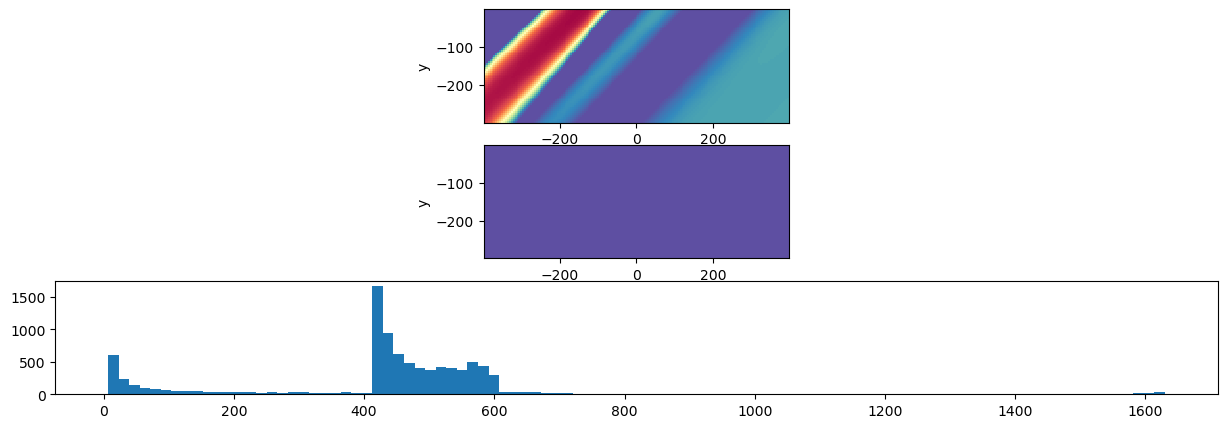

   9  3.33e-03  4.61e+03  1.48e+02  4.61e+03    4.83e+02      0              
geophys. misfits: 3984.0 (target 460.0 [False])
Beta cooling evaluation: progress: [3984.]; minimum progress targets: [4149.8]


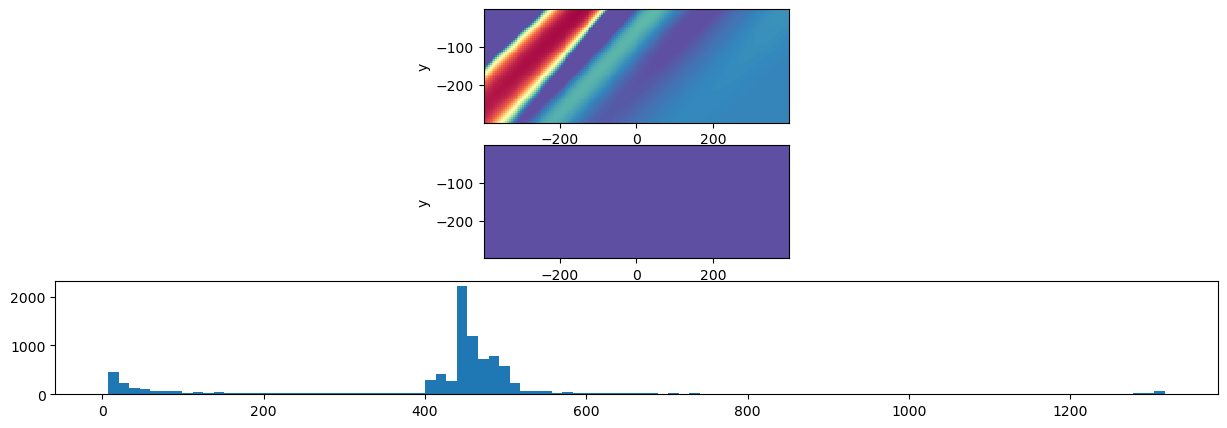

  10  3.33e-03  3.98e+03  1.63e+02  3.98e+03    4.92e+02      0              
geophys. misfits: 2871.8 (target 460.0 [False])
Beta cooling evaluation: progress: [2871.8]; minimum progress targets: [3585.6]


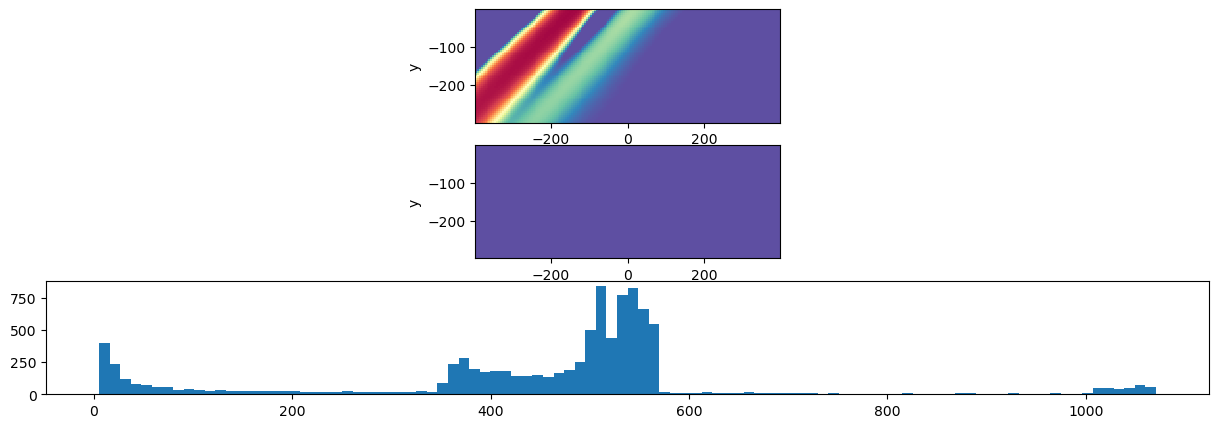

  11  3.33e-03  2.87e+03  2.15e+02  2.87e+03    3.88e+02      0              
geophys. misfits: 2455.5 (target 460.0 [False])
Beta cooling evaluation: progress: [2455.5]; minimum progress targets: [2584.6]


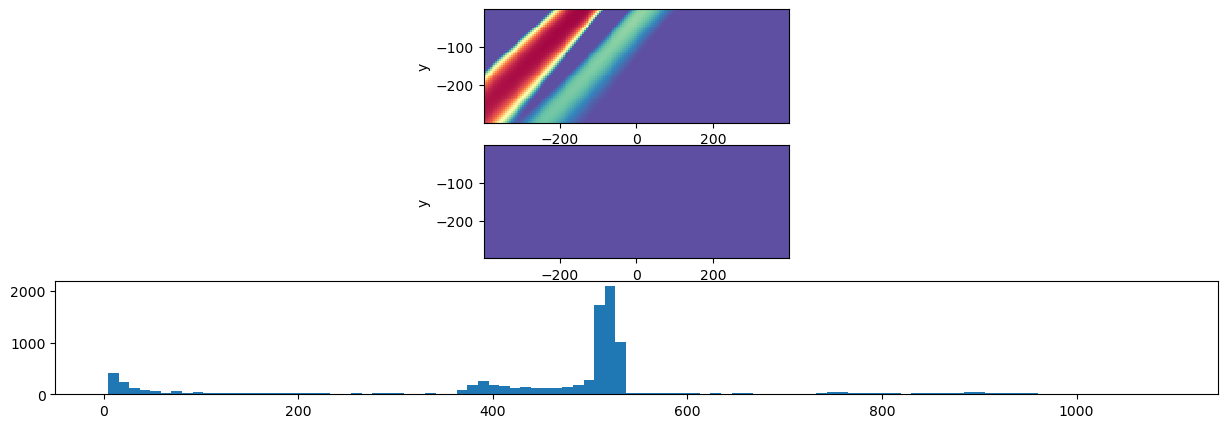

  12  3.33e-03  2.46e+03  2.68e+02  2.46e+03    3.11e+02      0              
geophys. misfits: 2131.0 (target 460.0 [False])
Beta cooling evaluation: progress: [2131.]; minimum progress targets: [2209.9]


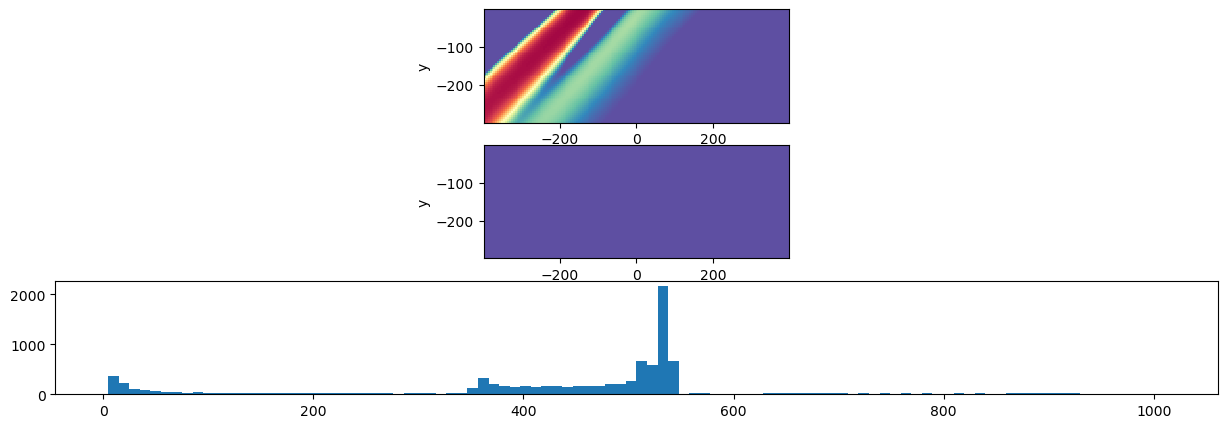

  13  3.33e-03  2.13e+03  2.68e+02  2.13e+03    3.52e+02      0              


KeyboardInterrupt: 

In [63]:
# --------------------------------------------------------------------------

# setup the inversion

#

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
m0 = np.log(1/500) * np.ones(mapping.nP)
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))
# set the regularization
alphas = np.ones((meshCore.n_cells, meshCore.dim))
# alphas[meshCore.cell_centers[:, 1] < 0.5] = [2, 1]
sqrt2 = np.sqrt(2)
# reg_dirs = np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],])

# lets just assign them to the dip structure
reg_cell_dirs = [np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],]) for _ in range(meshCore.nC)]

# # lets expand the area we want to
# # Dike 45*
# dike00 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 50)
# dike01 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 255)
# dike_dir_reg = np.logical_and(dike00,dike01)

# # reg model
# reg_model = model.copy()

# reg_model[dike_dir_reg]=4

# # cos = np.cos(140*np.pi / 180) * 2
# # sin = np.sin(140*np.pi / 180) * 2

# for ii in range(meshCore.nC):

#     if reg_model[actcore][ii] == 4:

#         # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
#         reg_cell_dirs[ii] = np.array([[sqrt2, sqrt2], [sqrt2, sqrt2],])

# reg_mean = GeologicalSegmentation(
#     meshCore, 
#     reg_dirs=None,
#     ortho_check=False,
#     segmentation_model=segmentor
# )
reg_mean = regularization.SmoothnessFullGradient(
    meshCore, 
    reg_dirs=reg_cell_dirs,
    ortho_check=False,
    # segmentation_model=segmentor
)

# # Weighting
# reg_mean = regularization.WeightedLeastSquares(
#     mesh, 
#     active_cells=actcore,
#     mapping=idenMap,
#     # reference_model=m0
# )
# reg_mean.alpha_s = 0.01
# reg_mean.alpha_x = 100
# reg_mean.alpha_y = 100
# reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=15, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

# Inversion directives
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True, coolingFactor=3.,
    warmingFactor=1., tolerance=0.05,
    progress=0.1
)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
# petrodir = PGIUpdateParameters(
#     update_covariances=True,
#     kappa = 1e8,
#     nu = 1e8,
#     update_rate = 2,
#     update_reference_model=False
#     )
# update_sam = update_segmentation_neighbours()
plot_iter_mref = plot_mref()
plot_iter_mref.mesh = meshCore
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e-2
inv = inversion.BaseInversion(invProb,
                            directiveList=[
                                            # updateSensW,
                                            #  update_sam,
                                            #  petrodir,
                                            targets, betaIt,
                                            #  MrefInSmooth,
                                            plot_iter_mref,
                                            #  save_pgi,
                                            # update_Jacobi,
                                            ])

# Run!

mcluster = inv.run(m0)

np.save("rotated_model_dip.npy", mcluster)
np.save("true_model_dip.npy", mtrue)
# mcluster = np.load("rotated_model.npy")

# plot
mm = meshCore.plot_image(
    
    1/(np.exp(mcluster)),
    ax=ax[2],
    clim=[0, 500],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[2].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[2].set_title('Rotated gradient recovered model')


In [64]:
dip_model = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_10.npy")

segmentor = geoseg.SamClassificationModel(
    meshCore,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)

masks = segmentor.fit(dip_model)

mask 0 vote total: 1
mask 1 vote total: 1
mask 2 vote total: 0
mask 3 vote total: 0
[1]
[[1.00000000e+00 5.63114567e-01 0.00000000e+00 0.00000000e+00]
 [5.63114567e-01 0.00000000e+00 4.31414923e-01 0.00000000e+00]
 [0.00000000e+00 4.31414923e-06 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [5]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [36]:
masks[7]['bbox']

[48, 80, 10, 18]

In [26]:
meshCore.cell_centers[48]

array([-155., -295.])

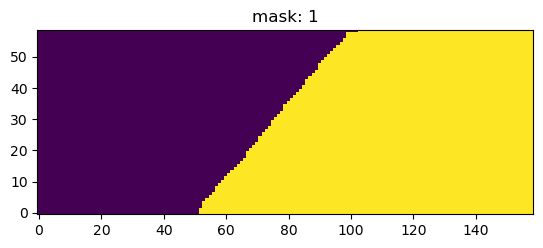

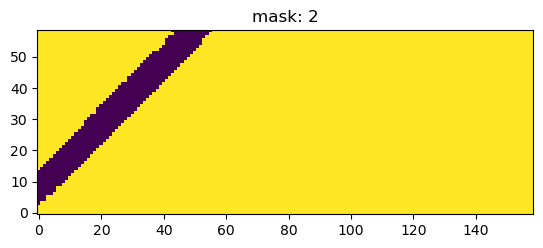

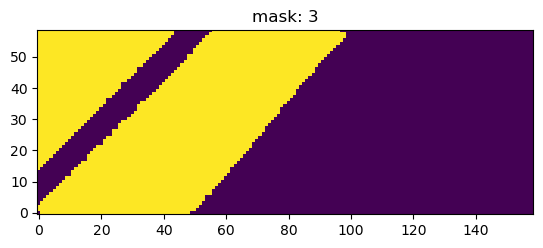

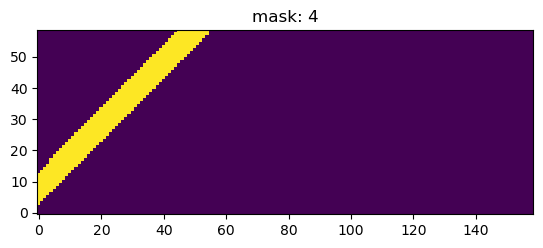

7


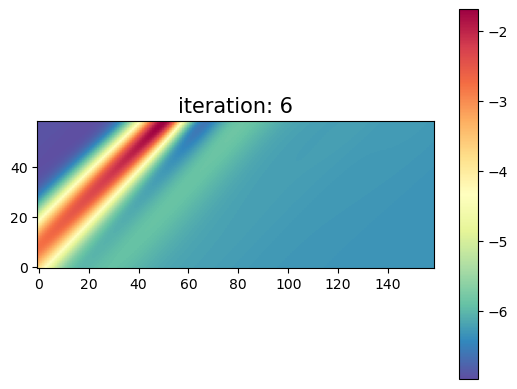

In [65]:
results = masks
cnt = 1
for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')

    plt.imshow(reshape.T)
    plt.title(f'mask: {cnt}')
    plt.gca().invert_yaxis()
    plt.show()
    cnt += 1
print(len(result))

flatten = dip_model
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T, cmap='Spectral_r')
plt.title(f'iteration: {6}',fontsize=15)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

mask 0: 527.4970290091933 ohm - m
mask 1: 429.0593062658765 ohm - m
mask 2: 318.1325656907928 ohm - m
mask 3: 12.488841553908351 ohm - m


/tmp/ipykernel_26009/2996460170.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})


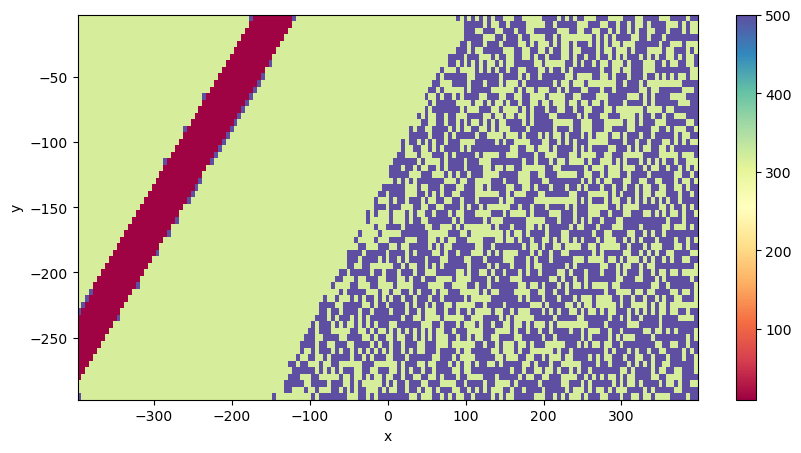

In [69]:
# masks[5]['area']
# bbox.shape
geological_model = segmentor.predict(dip_model)
fig, ax = plt.subplots(1,1, figsize=(10, 5))
dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

plt.colorbar(dat[0])

/tmp/ipykernel_26009/2106365333.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})
/tmp/ipykernel_26009/2106365333.py:10: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
/tmp/ipykernel_26009/2106365333.py:13: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[1, 0], pcolorOpts={'cmap':"winter_r"})
/tmp/ipykernel_26009/2106365333.py:16: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1

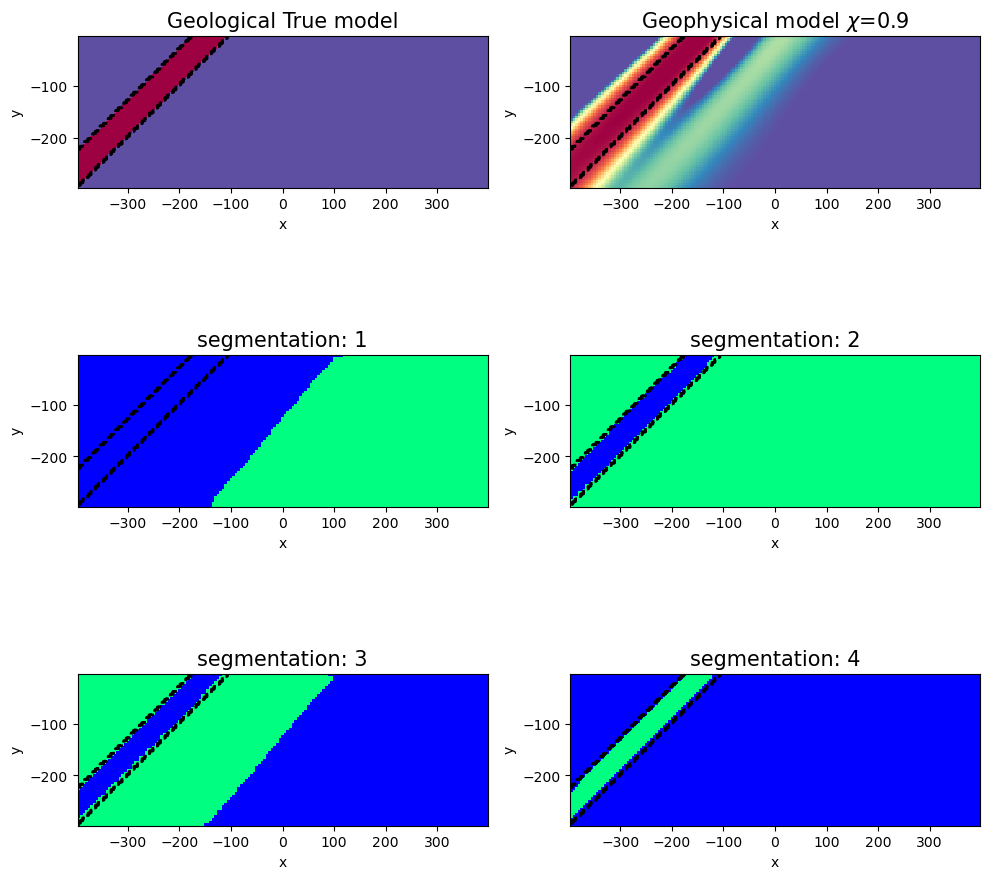

In [71]:
# sam_model = segmentor
# cond_true = mtrue
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

ax[0, 1].set_title(r'Geophysical model $\chi$=0.9',fontsize=15)

flatten = (cond_true)[actcore]
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
ax[0, 0].set_title('Geological True model',fontsize=15)
flatten = sam_model.masks[0]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[1, 0], pcolorOpts={'cmap':"winter_r"})
ax[1, 0].set_title('segmentation: 1',fontsize=15)
flatten = sam_model.masks[1]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[1, 1], pcolorOpts={'cmap':"winter_r"})
# ax[1, 1].invert_yaxis()
ax[1, 1].set_title('segmentation: 2',fontsize=15)

flatten = sam_model.masks[2]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[2, 0], pcolorOpts={'cmap':"winter_r"})
# ax[1, 1].invert_yaxis()
ax[2, 0].set_title('segmentation: 3',fontsize=15)

flatten = sam_model.masks[3]['segmentation'].flatten(order='F')
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[2, 1], pcolorOpts={'cmap':"winter_r"})
# ax[1, 1].invert_yaxis()
ax[2, 1].set_title('segmentation: 4',fontsize=15)

# flatten = sam_model.masks[4]['segmentation'].flatten(order='F')
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[3, 0], pcolorOpts={'cmap':"winter_r"})
# # ax[1, 1].invert_yaxis()
# ax[3, 0].set_title('segmentation: 5',fontsize=15)
# ax[3, 1].axis('off')
utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

plt.tight_layout()

# Bounding box

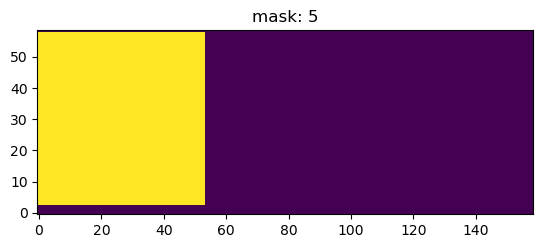

In [68]:
ii = 3
y0 = masks[ii]['bbox'][0]
x0 = masks[ii]['bbox'][1]
x1 = x0 + masks[ii]['bbox'][3]
y1 = y0 + masks[ii]['bbox'][2]

# generate as sparse matrix when things get big
bbox = np.zeros(masks[ii]['segmentation'].shape)

bbox[x0:x1, y0:y1] = 1
# bbox[x1, y1] = 1

flatten = bbox # masks[ii]['segmentation'].flatten(order='F')
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T)
plt.title(f'mask: {cnt}')
plt.gca().invert_yaxis()
# plt.plot([x0, x1], [y0, y1], 'ok')
plt.show()

/tmp/ipykernel_26009/1701524138.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})


(<matplotlib.contour.QuadContourSet at 0x7414a9031590>,
 <Axes: title={'center': 'Mask 4: Bounding box'}, xlabel='x', ylabel='y'>,
 <matplotlib.contour.QuadContourSet at 0x7414a96f7610>)

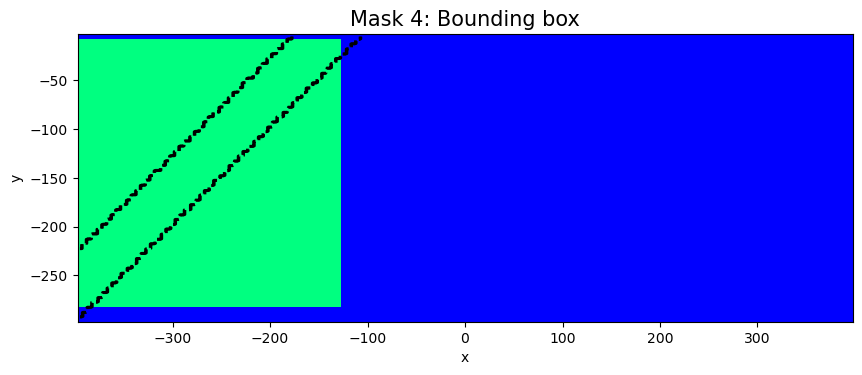

In [77]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
# dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})
flatten = reshape.flatten(order='F')  # (cond_true)[actcore]
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})
ax.set_title('Mask 4: Bounding box',fontsize=15)
# plt.colorbar(dat[0])

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)